# Feature importances and bias analysis of the churn models

Feature importance and bias analysis are crucial steps in evaluating a predictive model's performance and fairness. Feature importance indicates which variables have the most significant influence on the model's predictions. By understanding feature importance, we can gain insights into the dataset's underlying patterns and how different features impact the target outcome. This can inform feature engineering and the selection of an appropriate model.

Bias analysis, on the other hand, assesses whether the model's predictions are skewed or unfairly prejudiced towards certain groups or outcomes. This is vital to ensure that the model doesn't propagate or amplify existing inequalities or biases present in the data. Bias can manifest in various forms, such as overpredicting a certain class (like churn) for a specific demographic. Conducting bias analysis helps in creating fair and equitable predictive models, which is especially important in sensitive applications where decisions can have significant impacts on individuals' lives. Together, these analyses contribute to building robust, accurate, and fair machine learning systems.

In this analysis I am using the models with the best hyperparameters after performing GridSearch with focus on recall as a scoring metric. So they are optimized to predict as many churn cases as possible.

With this analysis I will also try to answer the question: "Is it reasonable to create a Voting classifier consisting from the fine-tuned models?"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [4]:
dataframe = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
nan_rows=dataframe[pd.to_numeric(dataframe['TotalCharges'], errors='coerce').isna()]
dataframe['TotalCharges'] = pd.to_numeric(dataframe['TotalCharges'], errors='coerce')
dataframe =dataframe.dropna(subset =['TotalCharges'])
dataframe=dataframe.drop(columns=['customerID'])

In [6]:
#first identifying the categorical variables
categorical_cols = dataframe.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn') #Let's not forget to remove the target variable!!!!!

In [7]:
df_encoded=pd.get_dummies(dataframe, columns=categorical_cols)*1
df_encoded['Churn'] = df_encoded['Churn'].map({'No': 0, 'Yes': 1})
df_encoded.head()


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


In [8]:
x = df_encoded.drop('Churn', axis=1)
y = df_encoded['Churn']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state = 50)

In [9]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler= StandardScaler()
scaler.fit(X_train[numerical_cols])

StandardScaler()

In [10]:
x_train_scaled = X_train.copy()
x_train_scaled[numerical_cols] = scaler.transform(X_train[numerical_cols])

x_test_scaled = X_test.copy()
x_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Logistic regression

In [11]:
lr_model_opt = LogisticRegression(C=0.1,penalty='l2', solver='liblinear', class_weight='balanced')
lr_model_opt.fit(x_train_scaled,y_train)

LogisticRegression(C=0.1, class_weight='balanced', solver='liblinear')

In [12]:
prediction=lr_model_opt.predict(x_test_scaled)
report=classification_report(y_test,prediction)
print(report)
print(lr_model_opt.score(x_test_scaled,y_test))

              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1561
           1       0.50      0.81      0.62       549

    accuracy                           0.74      2110
   macro avg       0.71      0.76      0.71      2110
weighted avg       0.80      0.74      0.75      2110

0.7388625592417062


#### Feature importances and bias analysis

In a logistic regression model, feature importances can be assessed by examining the coefficients assigned to each feature when predicting the target variable. These coefficients represent the log odds that the target variable equals 1 (e.g., for a binary classification problem), and they are determined during the model training process based on the logistic function.

Depending on the coefficients we can have the following interpretations:
- Positive Coefficients: A positive coefficient for a feature means that as the feature value increases, the log odds of the target variable being 1 also increases. In other words, there is a positive association between the feature and the likelihood of observing the outcome. For instance, if you are predicting the likelihood of a customer churning, a positive coefficient for monthly charges would indicate that higher monthly charges are associated with a higher likelihood of churn.
- Negative Coefficients: Conversely, a negative coefficient indicates that as the feature value increases, the log odds of the target variable being 1 decrease. There is a negative association between the feature and the likelihood of the outcome. Continuing with the churn example, a negative coefficient for tenure would suggest that the longer the tenure, the less likely the customer is to churn.
- Coefficient of Zero: If a coefficient is zero or near zero, it suggests that there is no linear relationship between the feature and the target variable's log odds.

In [13]:
X_test_lr = X_test.copy()
X_test_lr['Predicted'] = prediction
X_test_lr['Actual'] = y_test
false_positives = X_test_lr[(X_test_lr['Actual'] == 0) & (X_test_lr['Predicted'] == 1)]
false_negatives = X_test_lr[(X_test_lr['Actual'] == 1) & (X_test_lr['Predicted'] == 0)]

<Axes: ylabel='Feature'>

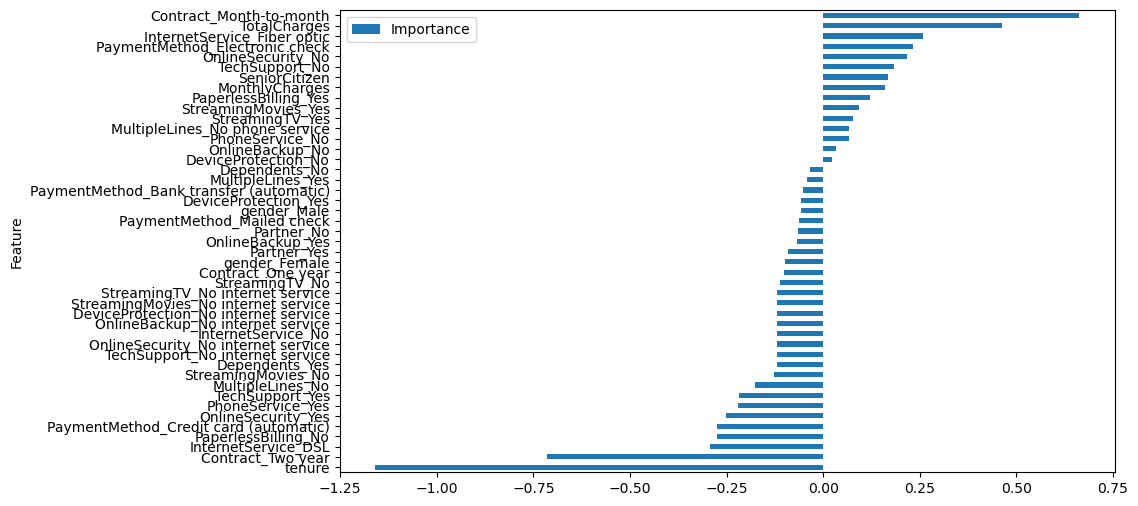

In [14]:
# Finding the most important features
coefficients = lr_model_opt.coef_[0]

feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': (coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

<Axes: ylabel='Feature'>

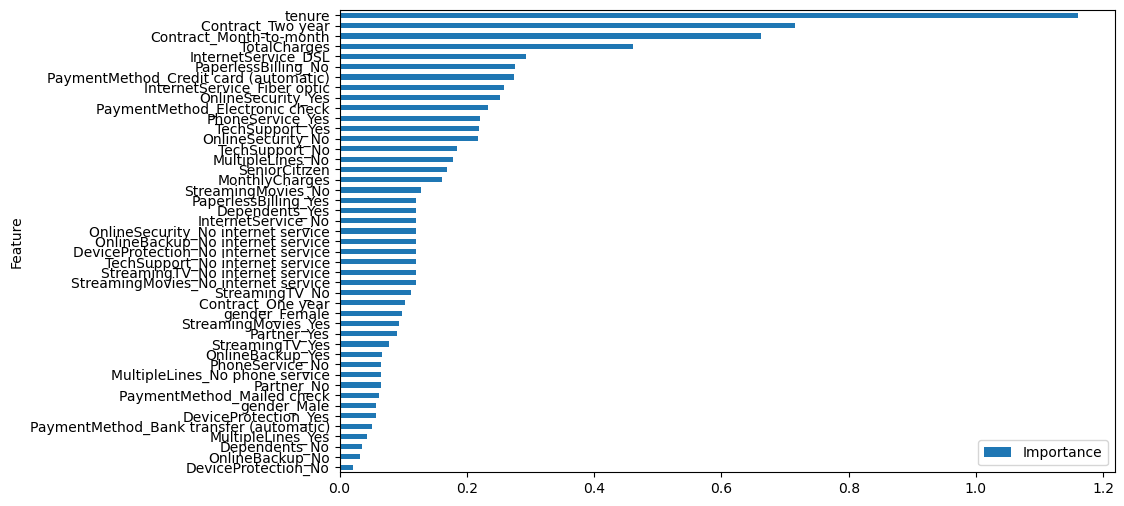

In [15]:
feature_importance = pd.DataFrame({'Feature': x.columns, 'Importance': np.abs (coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

As we can see from the plot, <b>TotalCharges Contract Month-to-month </b> (and others) have a positive relationship with churn. As the example mentioned above, this indicated that higher monthly charges and having a month-to-month contract are associated with a higher likelihood of churn.

Conversaly, <b>tenure and Contract Two year</b> have a negative relationship with churn. That would indicate that if the tenure is longer/ there is a two-year contract, it is less likely for the customer to churn.

For the biases analysis let's further examine the False Positives and False Negatives for these top 4 features (they are top 4 by their absolute values of their coefficients). 

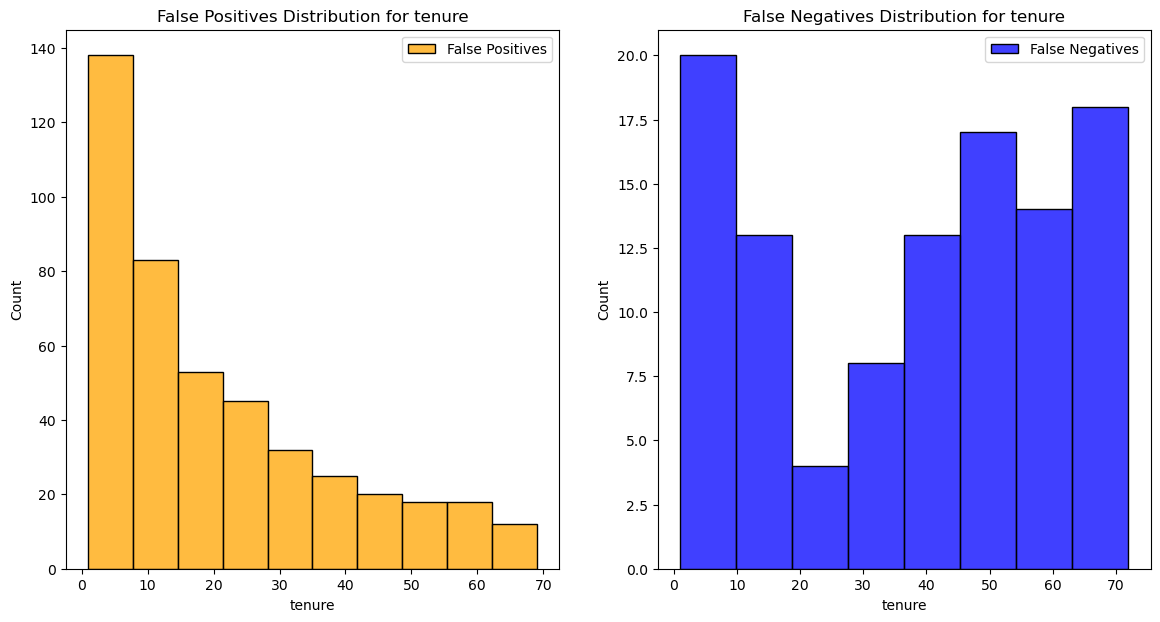

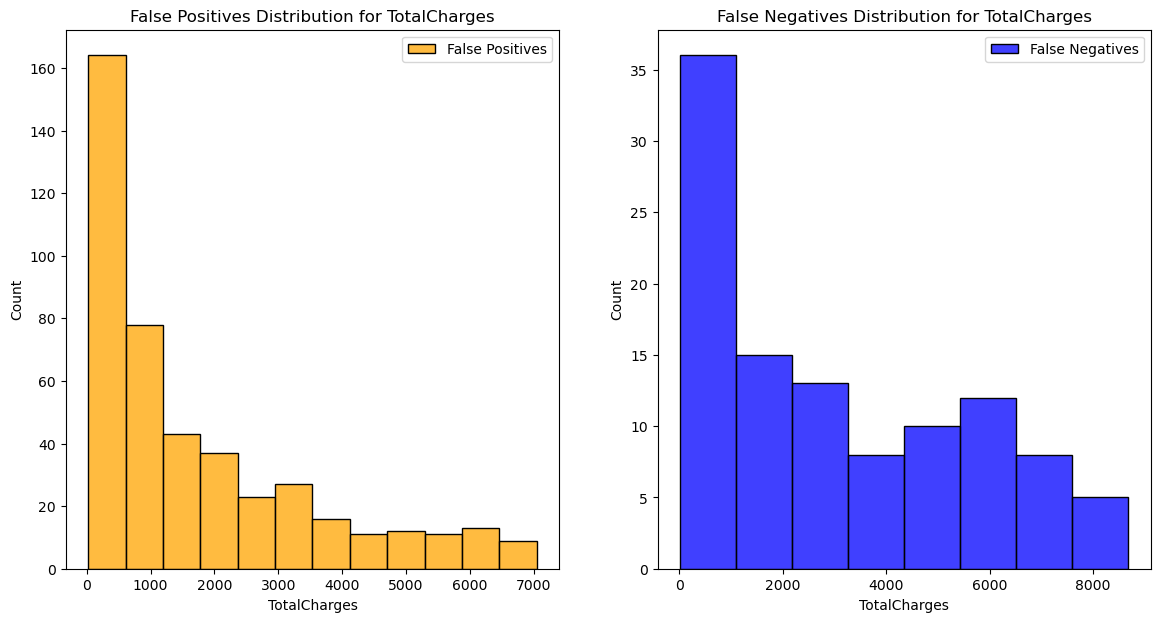

In [16]:
top_features = ['tenure', 'TotalCharges']

for feature in top_features:
    plt.figure(figsize=(14, 7))
    
    # Plot distribution of false positives for the feature
    plt.subplot(1, 2, 1)
    sns.histplot(false_positives[feature], kde=False, color='orange', label='False Positives')
    plt.title(f'False Positives Distribution for {feature}')
    plt.legend()
    
    # Plot distribution of false negatives for the feature
    plt.subplot(1, 2, 2)
    sns.histplot(false_negatives[feature], kde=False, color='blue', label='False Negatives')
    plt.title(f'False Negatives Distribution for {feature}')
    plt.legend()

    plt.show()

Tenure: False positives have a higher occurrence among customers with lower tenure, while false negatives are more spread out but also show a peak among customers with higher tenure. This suggests that the model might be more likely to incorrectly predict churn for newer customers and miss churn predictions for long-standing customers.

Total Charges: The false positives are more frequent at lower total charges, while false negatives are distributed across a wider range of total charges, with peaks at lower values. This might indicate that the model has difficulty accurately predicting churn for customers with very low charges.

These distributions indicate potential biases in the model:

Recency Bias: New customers (lower tenure) may be more likely to be falsely identified as churners.

Spending Bias: The model might be biased towards predicting churn incorrectly for those who spend less (lower total charges).

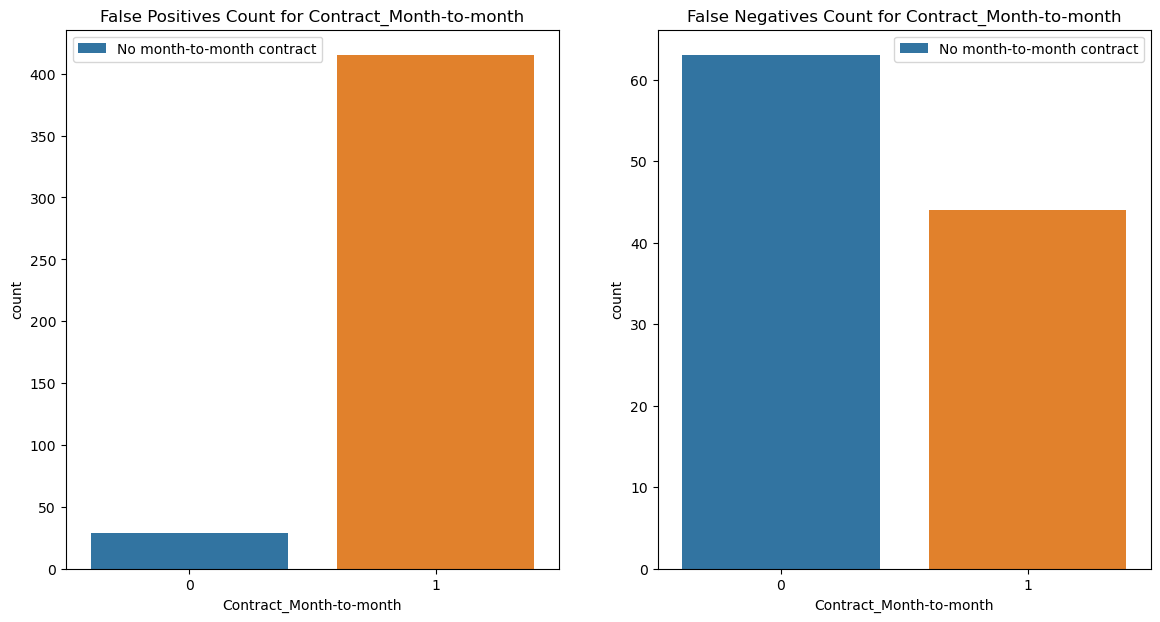

In [17]:
# Plot count distribution of false positives/negatives for Month-to-month contract
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x=false_positives['Contract_Month-to-month'], label='No month-to-month contract')
plt.title('False Positives Count for Contract_Month-to-month')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=false_negatives['Contract_Month-to-month'], label='No month-to-month contract')
plt.title('False Negatives Count for Contract_Month-to-month')
plt.legend()

plt.show()

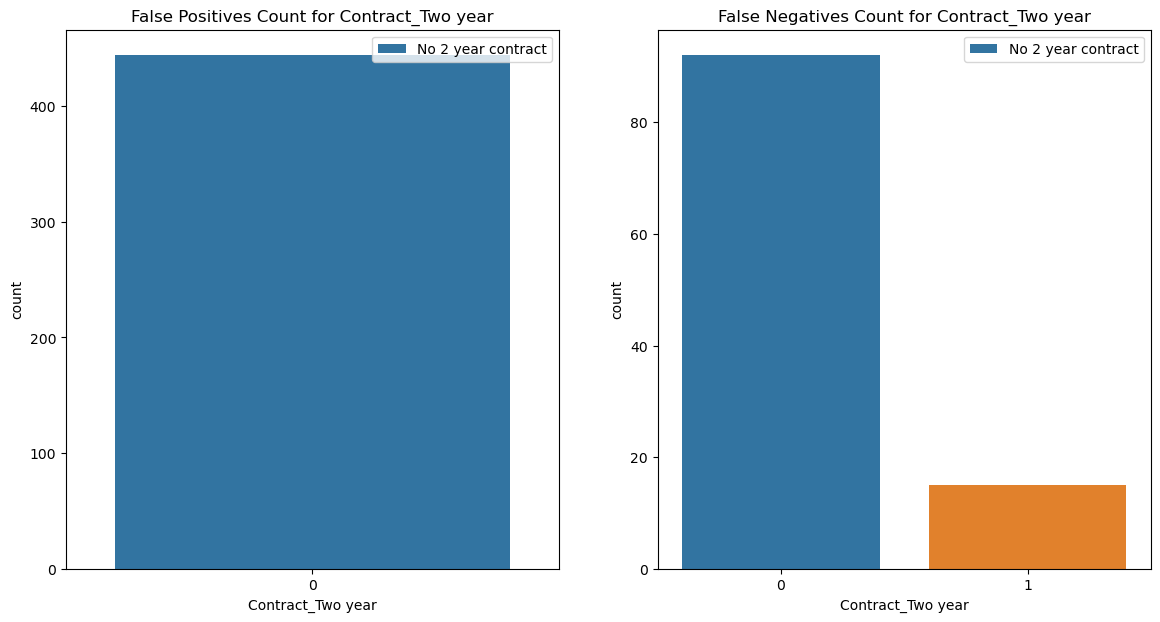

In [18]:
# Plot count distribution of false positives/negatives for One year contract
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x=false_positives['Contract_Two year'], label='No 2 year contract')
plt.title('False Positives Count for Contract_Two year')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=false_negatives['Contract_Two year'], label='No 2 year contract')
plt.title('False Negatives Count for Contract_Two year')
plt.legend()

plt.show()

Month-to-month contract: False positives are higher among customers with month-to-month contracts. This suggests that the model might be more likely to incorrectly predict churn for customers with short-term contracts. False negatives are more evenly distributed across the two classes but still it seems that the model fails to predict customers as churning when they have longer contracts.

Two year contract: All of the False positives are among customers with no month-to-month contracts. On the other hand False negatives are also higher among customers who have contracts different from a two year contract. It seems that the model incorrectly predicts churn for customers that don't have two year contracts and at the same time fails to predict some churning customers with the same class.


# Random Forest

In [19]:
rf_model_opt=RandomForestClassifier(class_weight='balanced_subsample', max_depth=10, n_estimators=50)
rf_model_opt.fit(x_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       n_estimators=50)

In [20]:
rf_prediction = rf_model_opt.predict(x_test_scaled)
rf_report=classification_report(y_test, rf_prediction)
print(rf_report)
print(rf_model_opt.score(x_test_scaled,y_test))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84      1561
           1       0.55      0.70      0.62       549

    accuracy                           0.77      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.80      0.77      0.78      2110

0.7734597156398104


#### Feature importances analysis

In a Random Forest model, feature importances are assessed differently compared to logistic regression because Random Forest is an ensemble method that operates through decision trees, which are non-linear models. There are two types of methods to find the feature importances for a RF model:

- Gini Importance or Mean Decrease in Impurity (MDI):  When a feature is used to split a node, it contributes to the reduction of the Gini impurity—a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. The more a feature decreases the impurity, the more important it is considered.
- Permutation Importance or Mean Decrease in Accuracy (MDA): This assesses the importance of a feature by calculating the decrease in the model's accuracy when the values of that feature are randomly permuted. A significant decrease in model performance indicates that the model relied on the feature for the prediction.

Interpretation:
- Higher Values: A high importance score for a feature means that changing the values of this feature, on average, leads to significant changes in the model output. Such features are considered more important for making predictions.

- Lower Values: A low importance score suggests that altering the feature's values does not significantly affect the model's predictions. These features are less critical in the model's decision-making process.

We can calculate feature importances by accessing the feature_importances_ attribute of the RandomForestClassifier object which is based on mean decrease in impurity.

In [21]:
importances = rf_model_opt.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model_opt.estimators_], axis=0)
indices = np.argsort(importances)[::-1]
col_names = x_train_scaled.columns.tolist()
print("Feature ranking:")
for f in range(X_test.shape[1]):
    print(f"{f + 1}. {col_names[indices[f]]} ({importances[indices[f]]})")

Feature ranking:
1. tenure (0.11401624051651929)
2. TotalCharges (0.10976846091103187)
3. Contract_Month-to-month (0.10930005283896559)
4. MonthlyCharges (0.07559278451967545)
5. Contract_Two year (0.061757753623069685)
6. OnlineSecurity_No (0.05442095914198118)
7. TechSupport_No (0.048560952931723786)
8. PaymentMethod_Electronic check (0.039038304649999994)
9. InternetService_Fiber optic (0.03556347430586428)
10. Contract_One year (0.0209042539681638)
11. InternetService_DSL (0.017373333391020963)
12. PaperlessBilling_Yes (0.015457332872588549)
13. OnlineBackup_No (0.015285040517449024)
14. PaperlessBilling_No (0.014948589439337618)
15. OnlineSecurity_Yes (0.014300215049906346)
16. TechSupport_Yes (0.014230303398244916)
17. DeviceProtection_No (0.014127708950070783)
18. gender_Male (0.011399051767501995)
19. Partner_No (0.010532339675600801)
20. OnlineBackup_Yes (0.010489291528801707)
21. Dependents_Yes (0.010433788018588725)
22. Partner_Yes (0.010418764136691907)
23. PaymentMethod_Cr

Let's take the top 4 most important features  for the model (<b>tenure, Contract month-to-month, TotalCharges, MonthlyCharges) and Contract Two year</b> (so to later compare it with the biases of LG) and further analyze if there is any bias.

#### Bias analysis

In [22]:
X_test_with_predictions = X_test.copy()
X_test_with_predictions['Predicted'] = rf_prediction
X_test_with_predictions['Actual'] = y_test

In [23]:
X_test_with_predictions

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Predicted,Actual
4460,0,18,78.20,1468.75,0,1,0,1,1,0,...,0,0,1,0,0,0,1,0,0,0
733,0,72,79.05,5730.70,1,0,0,1,0,1,...,0,1,1,0,1,0,0,0,0,0
5514,0,1,48.45,48.45,1,0,1,0,1,0,...,0,0,0,1,1,0,0,0,1,0
5864,0,47,19.65,921.55,1,0,0,1,1,0,...,0,1,1,0,1,0,0,0,0,0
916,1,23,75.40,1643.55,1,0,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2672,0,27,20.10,562.60,0,1,1,0,1,0,...,1,0,1,0,1,0,0,0,0,0
5697,0,70,109.50,7674.55,1,0,0,1,1,0,...,1,0,0,1,0,0,1,0,0,1
2426,0,17,35.65,646.05,1,0,0,1,1,0,...,0,0,0,1,0,1,0,0,0,0
4787,0,4,54.70,235.05,1,0,0,1,1,0,...,0,0,1,0,0,0,0,1,0,0


In [24]:
false_positives = X_test_with_predictions[(X_test_with_predictions['Actual'] == 0) & (X_test_with_predictions['Predicted'] == 1)]
false_negatives = X_test_with_predictions[(X_test_with_predictions['Actual'] == 1) & (X_test_with_predictions['Predicted'] == 0)]

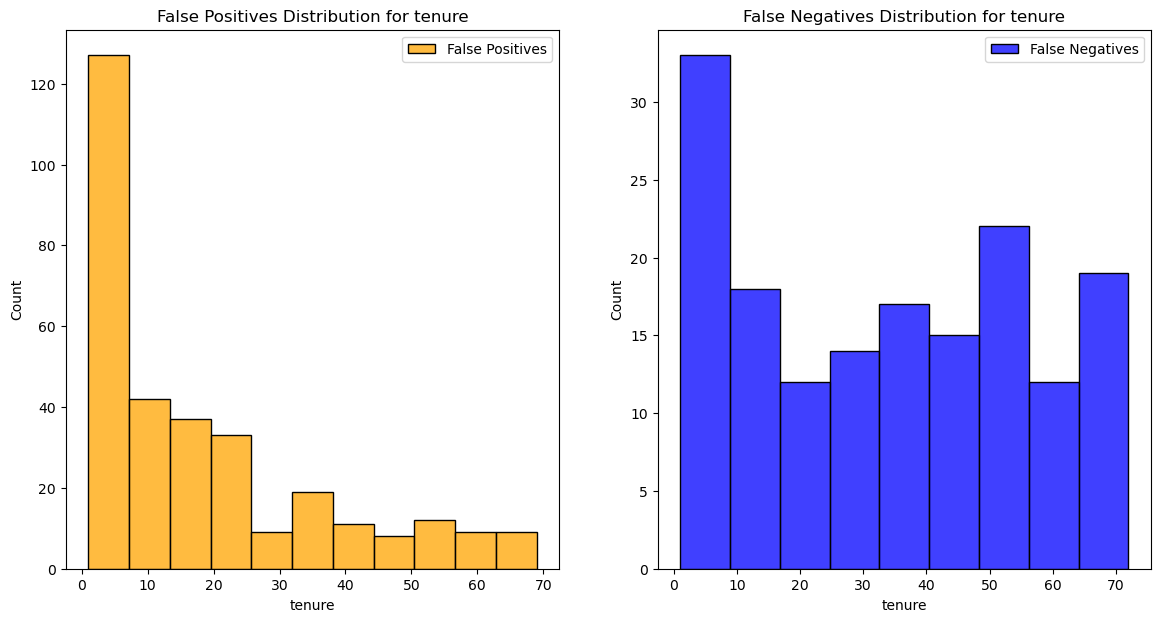

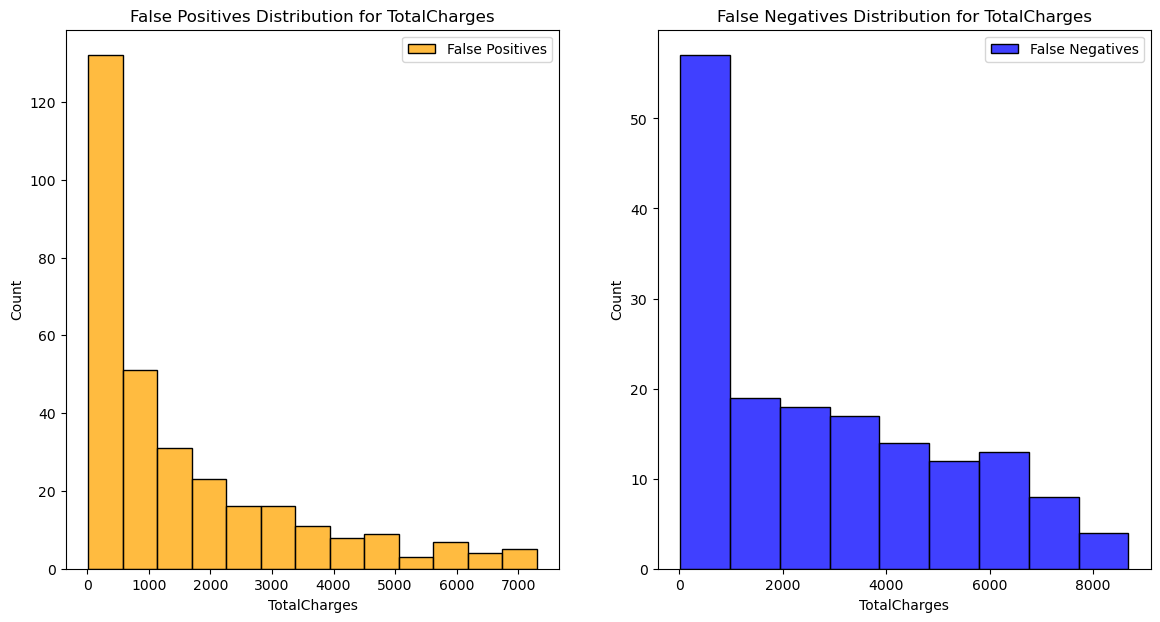

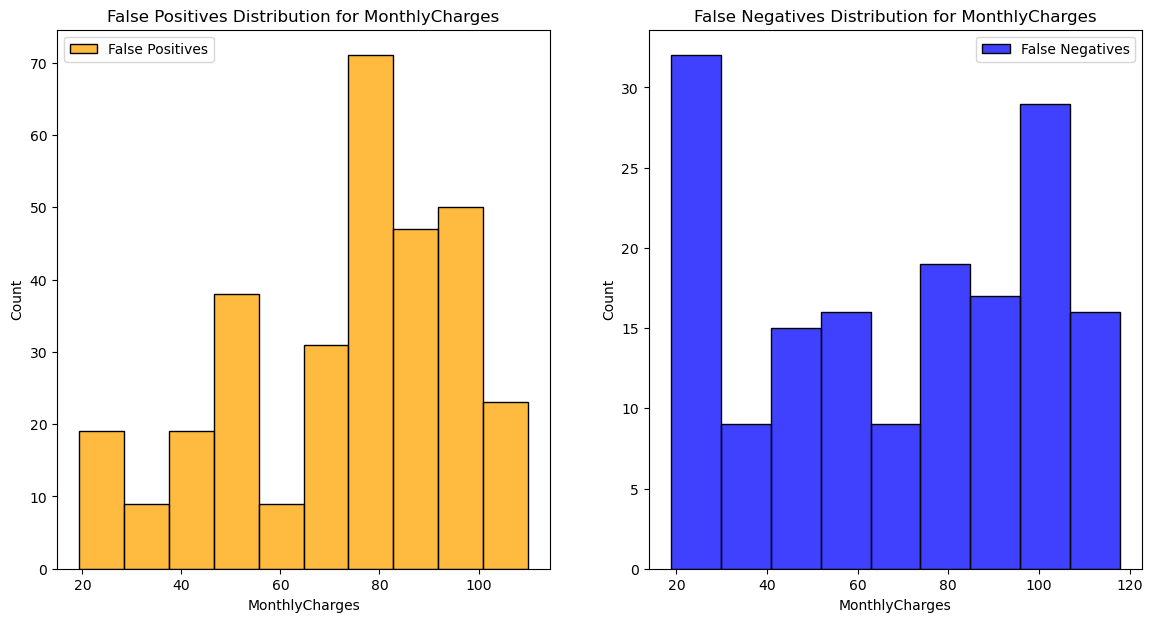

In [25]:
top_features = ['tenure', 'TotalCharges', 'MonthlyCharges']


for feature in top_features:
    plt.figure(figsize=(14, 7))
    
    # Plot distribution of false positives for the feature
    plt.subplot(1, 2, 1)
    sns.histplot(false_positives[feature], kde=False, color='orange', label='False Positives')
    plt.title(f'False Positives Distribution for {feature}')
    plt.legend()
    
    # Plot distribution of false negatives for the feature
    plt.subplot(1, 2, 2)
    sns.histplot(false_negatives[feature], kde=False, color='blue', label='False Negatives')
    plt.title(f'False Negatives Distribution for {feature}')
    plt.legend()

    plt.show()


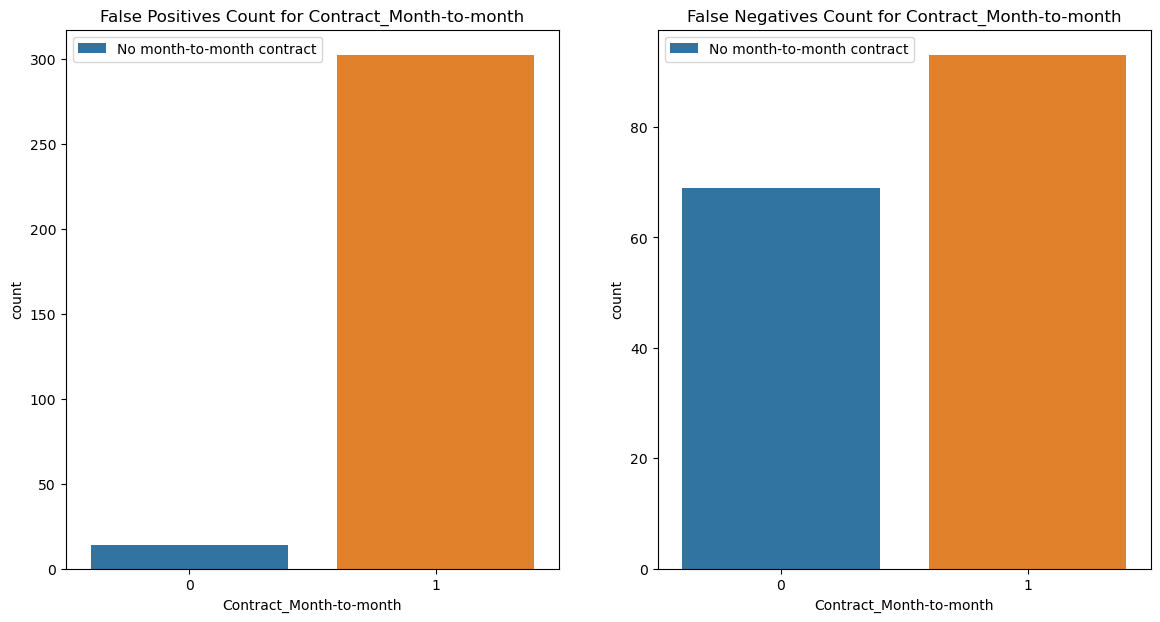

In [26]:
# Plot count distribution of false positives/negatives for Month-to-month contract
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x=false_positives['Contract_Month-to-month'], label='No month-to-month contract')
plt.title('False Positives Count for Contract_Month-to-month')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=false_negatives['Contract_Month-to-month'], label='No month-to-month contract')
plt.title('False Negatives Count for Contract_Month-to-month')
plt.legend()

plt.show()


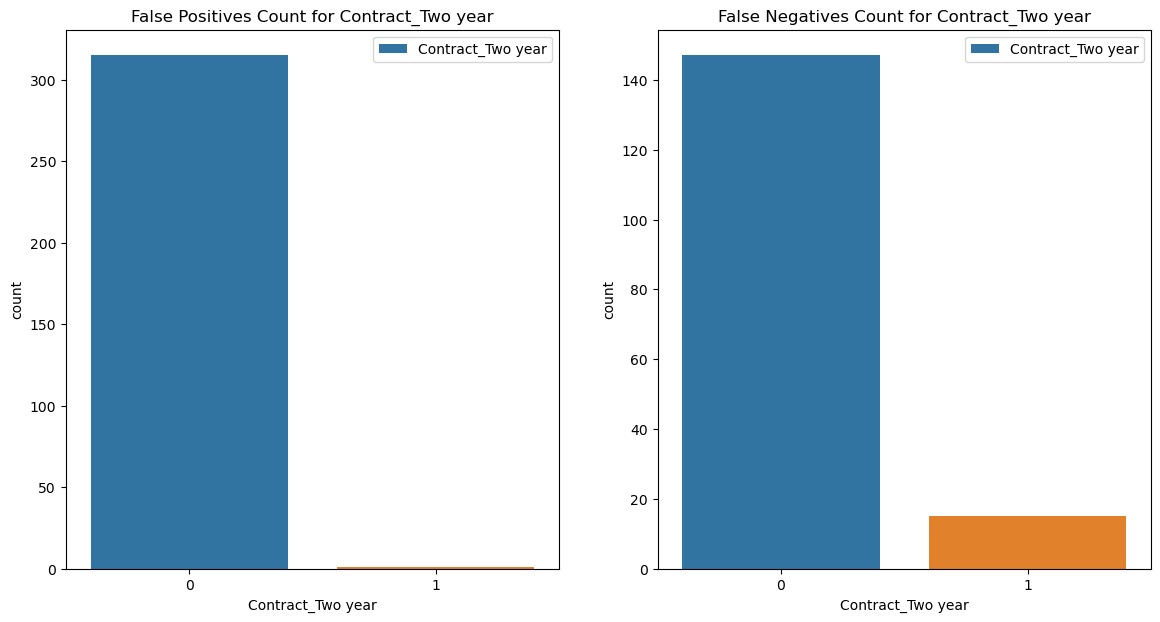

In [27]:
# Plot count distribution of false positives/negatives for Online Security
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x=false_positives['Contract_Two year'], label='Contract_Two year')
plt.title('False Positives Count for Contract_Two year')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=false_negatives['Contract_Two year'], label='Contract_Two year')
plt.title('False Negatives Count for Contract_Two year')
plt.legend()

plt.show()


Let's analyze the false positives and false negatives distribution for the top features from the Random Forest model:

Tenure: False positives are heavily skewed towards lower tenure, while false negatives are more evenly distributed with peaks at lower and higher tenures. This indicates that the model might be biased towards predicting churn for customers with a shorter tenure.

TotalCharges: False positives are skewed towards the lower end of total charges, suggesting that the model may incorrectly predict churn for customers who have spent less overall. False negatives are more evenly distributed across total charges, with a peak in lower values.

MonthlyCharges: Both false positives and false negatives are distributed across the range of monthly charges, with some peaks, indicating that monthly charges might not be as strong a predictor for churn as tenure or total charges.

Contract_Month-to-month: There is a clear bias in the model towards predicting churn for customers with month-to-month contracts, as seen by the high number of false positives. Conversely, the model tends to miss churn predictions (false negatives) for both of the classes (with and without month-to-month contract).

Two year contract: All false positives are observed for customers with no two year contract, implying that the lack of two year contract is a strong predictor for churn according to the model. At the same time it still misses (false negatives) a lot of customers with no two year contracts. 

# SVM

Determining feature importances in Support Vector Machine (SVM) models, especially with non-linear kernels like RBF, is not as straightforward as it is in models like Decision Trees or Random Forests. SVM models, particularly with RBF kernels, do not provide a direct way to assess feature importance because they work by mapping input features into high-dimensional space and finding a hyperplane that best separates the classes.

For non-linear kernels like RBF, model-agnostic methods like Permutation Importance can be applied. Permutation Importance involves randomly shuffling each feature one at a time in the validation dataset and measuring the change in the model's performance. A significant decrease in model performance upon shuffling indicates high importance. This is what I decide to do in this case.

In [28]:
from sklearn.inspection import permutation_importance

In [29]:
svm_model_opt_rbf= SVC(kernel='rbf', C=1, class_weight='balanced',gamma=0.01)
svm_model_opt_rbf.fit(x_train_scaled,y_train)

SVC(C=1, class_weight='balanced', gamma=0.01)

In [30]:
svm_prediction_rbf=svm_model_opt_rbf.predict(x_test_scaled)
svm_report_rbf=classification_report(y_test, svm_prediction_rbf)
print(svm_report_rbf)
print(svm_model_opt_rbf.score(x_test_scaled,y_test))

              precision    recall  f1-score   support

           0       0.92      0.67      0.77      1561
           1       0.47      0.83      0.60       549

    accuracy                           0.71      2110
   macro avg       0.69      0.75      0.69      2110
weighted avg       0.80      0.71      0.73      2110

0.7113744075829384


I will try the method permutation_importance with different scoring metrics, taking into account that the dataset is imbalanced and 'accuracy' might not be the best scoring metric in this case. Nevertheless I will perform permutation importance with accuracy and recall so as to compare the results.

In [31]:
result = permutation_importance(
    svm_model_opt_rbf, 
    x_test_scaled.sample(frac=0.5, random_state=42), 
    y_test.sample(frac=0.5, random_state=42), 
    n_repeats=50, 
    random_state=42, 
    n_jobs=-1,
    scoring='accuracy'
)

In [32]:
# Sort the features by their importance scores
sorted_idx = result.importances_mean.argsort()

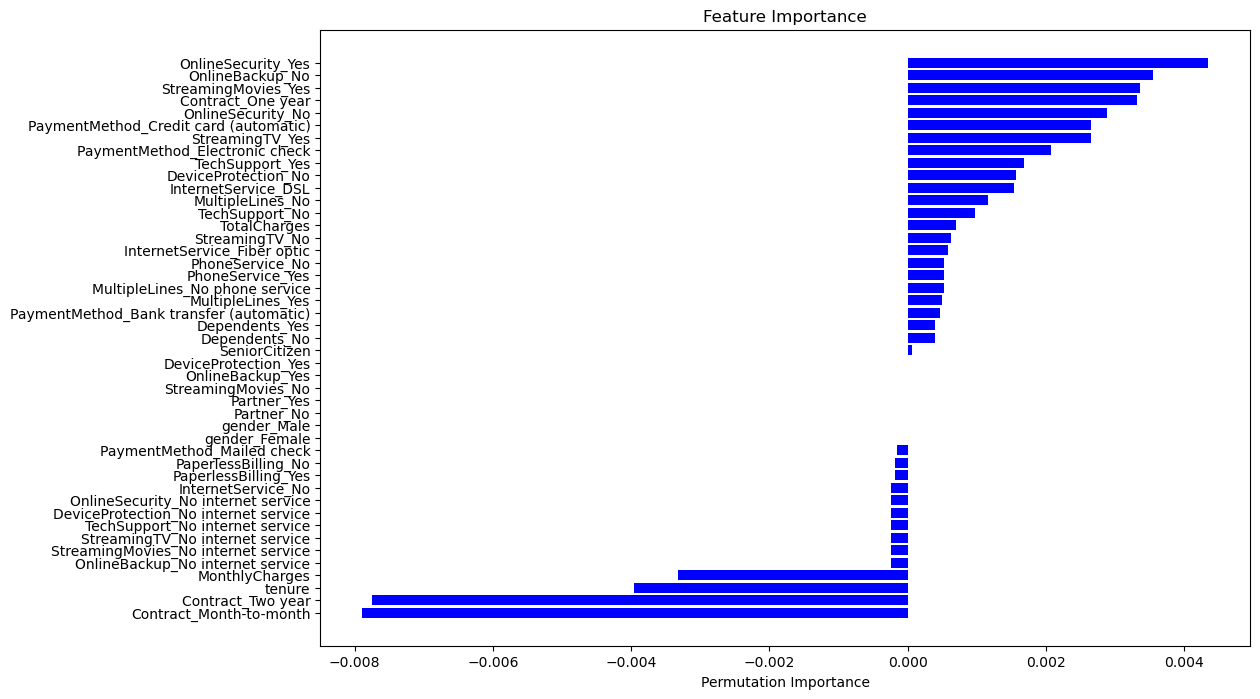

In [33]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], color='blue', align='center')
plt.yticks(range(len(sorted_idx)), [col_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

#### Recall

In [34]:
result = permutation_importance(
    svm_model_opt_rbf, 
    x_test_scaled.sample(frac=0.5, random_state=42), 
    y_test.sample(frac=0.5, random_state=42), 
    n_repeats=50, 
    random_state=42, 
    n_jobs=-1,
    scoring='recall'
)

In [35]:
# Sort the features by their importance scores
sorted_idx = result.importances_mean.argsort()

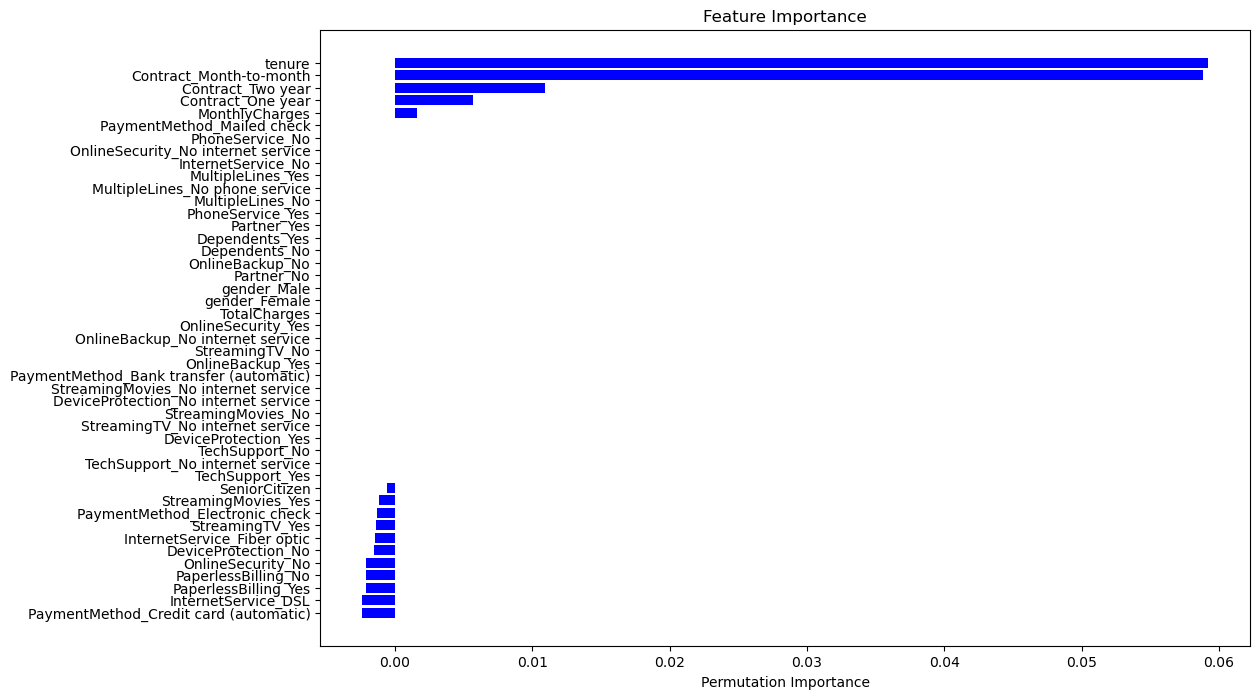

In [36]:
plt.figure(figsize=(12, 8))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], color='blue', align='center')
plt.yticks(range(len(sorted_idx)), [col_names[i] for i in sorted_idx])
plt.xlabel('Permutation Importance')
plt.title('Feature Importance')
plt.show()

What is the interpretation?

Positive Scores: Features with positive importance scores on the right side of the plot are considered useful for the model. Their permutation (shuffling of values) led to a decrease in model performance, suggesting that the model relies on these features for making accurate predictions. The longer the bar, the more important the feature is deemed to be.

Negative Scores: Features with negative importance scores on the left side of the plot are peculiar as their permutation leads to an improvement in model performance or no change. This can imply several things:

- The model might be overfitting to these features, and shuffling them reduces overfitting, thus improving model performance.
- The features could be introducing noise rather than useful information. 
- There could be an interaction between features that is not captured well by the model, and shuffling these features may be affecting these interactions in a way that is not intuitive.
- It could also be due to the randomness in the permutation process, especially if n_repeats is not large enough to average out the variations.

Features with negative importance scores can usually be considered as not helpful or even harmful to the model's ability to generalize, and thus might be candidates for removal from the model.

No Bars/Short Bars: Features with very short or no bars are considered to have no significant impact on model performance when permuted. These features likely do not contribute meaningful information for predictions in the context of the current model.
 

What's surprising is that for this model OnlineSecurity_Yes, OnlineBackup_No and StreamingMovies_Yes are the most important features. 

What's even more surprising is that tenure, MonthlyCharges, Contract_ Two year and Contract_Month-to-month improve the model's performance when shuffled. This analysis changes the perspective completely. Maybe those features are harmful and missleading for the model and it's worth removing them? Or is it just an artifact of this paricular modeling technique? 

When considering <b> recall </b> the most important features seem to be <b> tenure, Contract month-to-month, Contract Two and One year </b>.

Concerning is the fact that the permutation importance shows that permuting a feature drops the accuracy by at most 0.004, which would suggest that none of the features are important.

<b>It's important to note that when two features are correlated and one of the features is permuted, the model will still have access to the feature through its correlated feature. This will result in a lower importance value for both features, where they might actually be important. </b>

Let's try to handle multicollinearity when performing permutation importance. I will do  hierarchical clustering on the features’ Spearman rank-order correlations, picking a threshold, and keeping a single feature from each cluster.

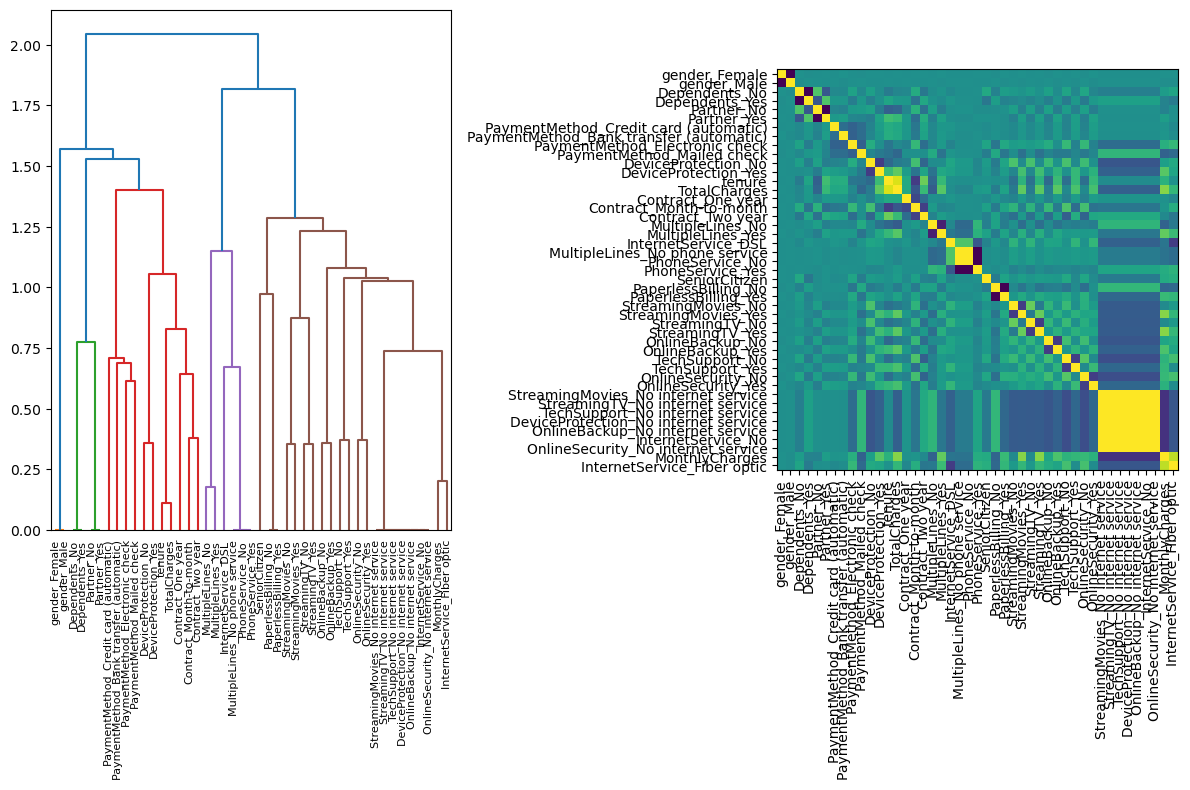

In [37]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(x).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=x.columns.to_list(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
_ = fig.tight_layout()

In [38]:
from collections import defaultdict

#from the dendogram I decide for the threshold to be 1.25
cluster_ids = hierarchy.fcluster(dist_linkage, 1.25, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_features_names = x.columns[selected_features]

X_train_sel = X_train[selected_features_names]
X_test_sel = X_test[selected_features_names]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Baseline accuracy on test data with features removed:"
    f" {clf_sel.score(X_test_sel, y_test):.2}"
)

Baseline accuracy on test data with features removed: 0.76


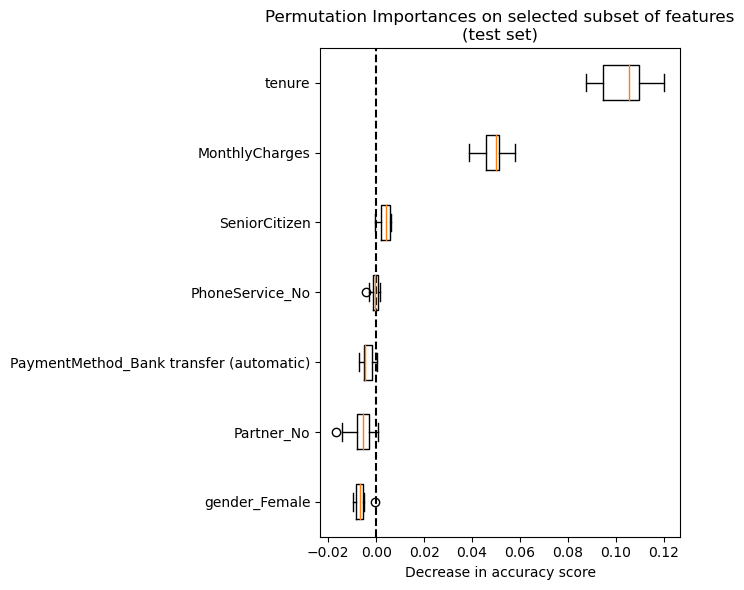

In [39]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2, scoring='accuracy')
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
plt.show()


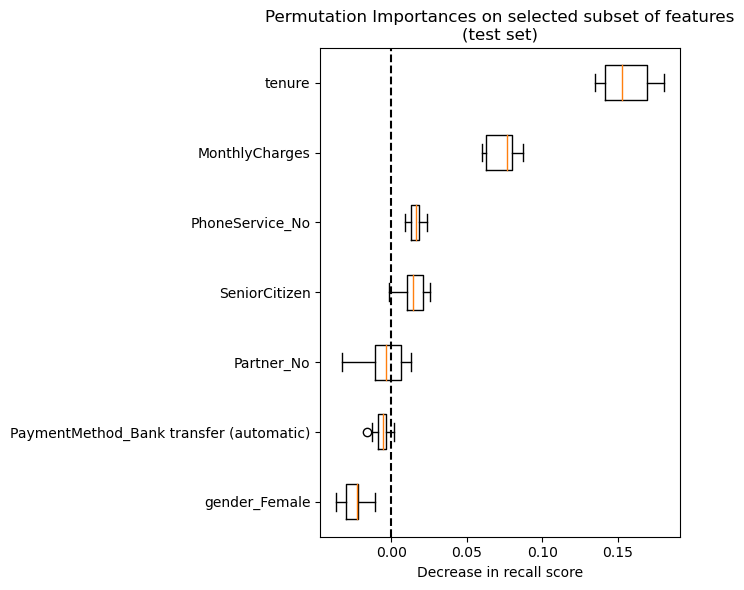

In [40]:
def plot_permutation_importance(clf, X, y, ax):
    result = permutation_importance(clf, X, y, n_repeats=10, random_state=42, n_jobs=2, scoring='recall')
    perm_sorted_idx = result.importances_mean.argsort()

    ax.boxplot(
        result.importances[perm_sorted_idx].T,
        vert=False,
        labels=X.columns[perm_sorted_idx],
    )
    ax.axvline(x=0, color="k", linestyle="--")
    return ax

fig, ax = plt.subplots(figsize=(7, 6))
plot_permutation_importance(clf_sel, X_test_sel, y_test, ax)
ax.set_title("Permutation Importances on selected subset of features\n(test set)")
ax.set_xlabel("Decrease in recall score")
ax.figure.tight_layout()
plt.show()


It appears that <b> tenure and MonthlyCharges </b> are the most influential features in the model's predictions for both accuracy and recall.  This suggests that the length of time a customer has been with the company (tenure) and the amount they are charged each month (MonthlyCharges) are critical factors in predicting customer churn.

For now I decide to further examine the most common features <b>tenure, TotalCharges, MothlyCharges, Contract two year, Contract Month-to-month </b> to understand potential biases. I want to check if the SVM model has the same or different biases for these features as the other two algorithms.  If the biases of the models are complementary, an ensemble model, like a voting classifier, can leverage the diversity of the models to improve performance. The ensemble approach can help to smooth out the predictions, reducing the chance of overfitting to the biases present in individual models.

#### Bias analysis

In [41]:
X_test_svm = X_test.copy()
X_test_svm['Predicted'] = svm_prediction_rbf
X_test_svm['Actual'] = y_test
false_positives = X_test_svm[(X_test_svm['Actual'] == 0) & (X_test_svm['Predicted'] == 1)]
false_negatives = X_test_svm[(X_test_svm['Actual'] == 1) & (X_test_svm['Predicted'] == 0)]

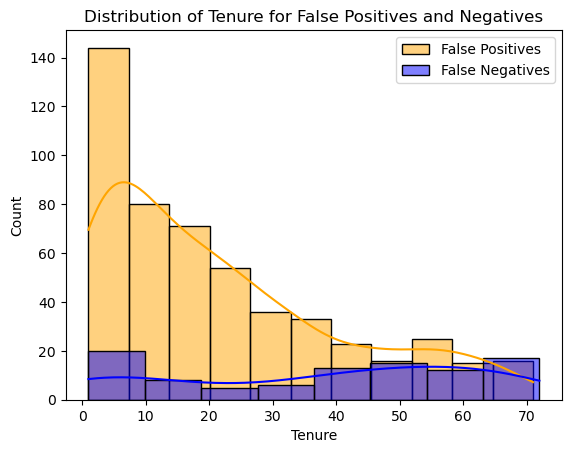

In [42]:
sns.histplot(data=false_positives['tenure'], color='orange', label='False Positives', kde=True)
sns.histplot(data=false_negatives['tenure'], color='blue', label='False Negatives', kde=True)
plt.legend()
plt.title('Distribution of Tenure for False Positives and Negatives')
plt.xlabel('Tenure')
plt.ylabel('Count')
plt.show()

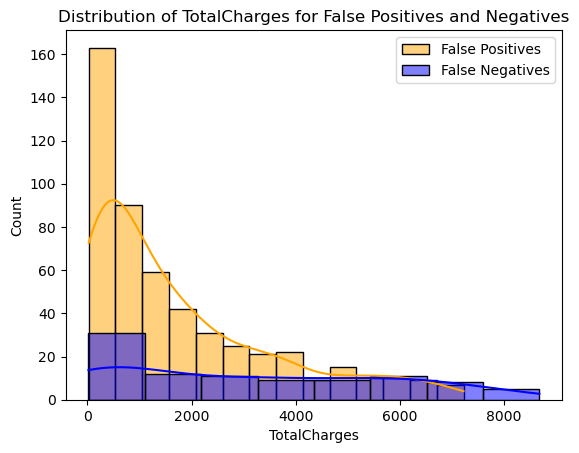

In [43]:
sns.histplot(data=false_positives['TotalCharges'], color='orange', label='False Positives', kde=True)
sns.histplot(data=false_negatives['TotalCharges'], color='blue', label='False Negatives', kde=True)
plt.legend()
plt.title('Distribution of TotalCharges for False Positives and Negatives')
plt.xlabel('TotalCharges')
plt.ylabel('Count')
plt.show()

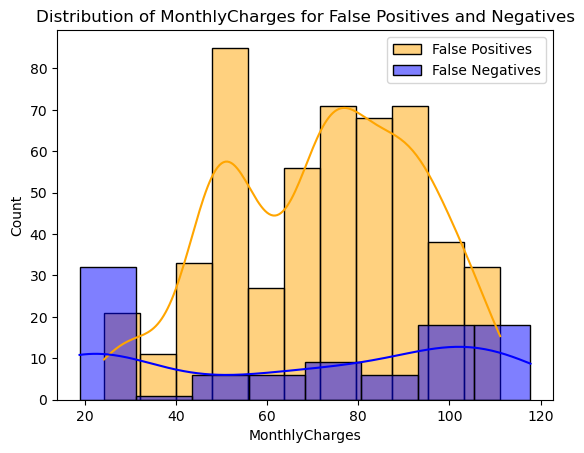

In [44]:
sns.histplot(data=false_positives['MonthlyCharges'], color='orange', label='False Positives', kde=True)
sns.histplot(data=false_negatives['MonthlyCharges'], color='blue', label='False Negatives', kde=True)
plt.legend()
plt.title('Distribution of MonthlyCharges for False Positives and Negatives')
plt.xlabel('MonthlyCharges')
plt.ylabel('Count')
plt.show()

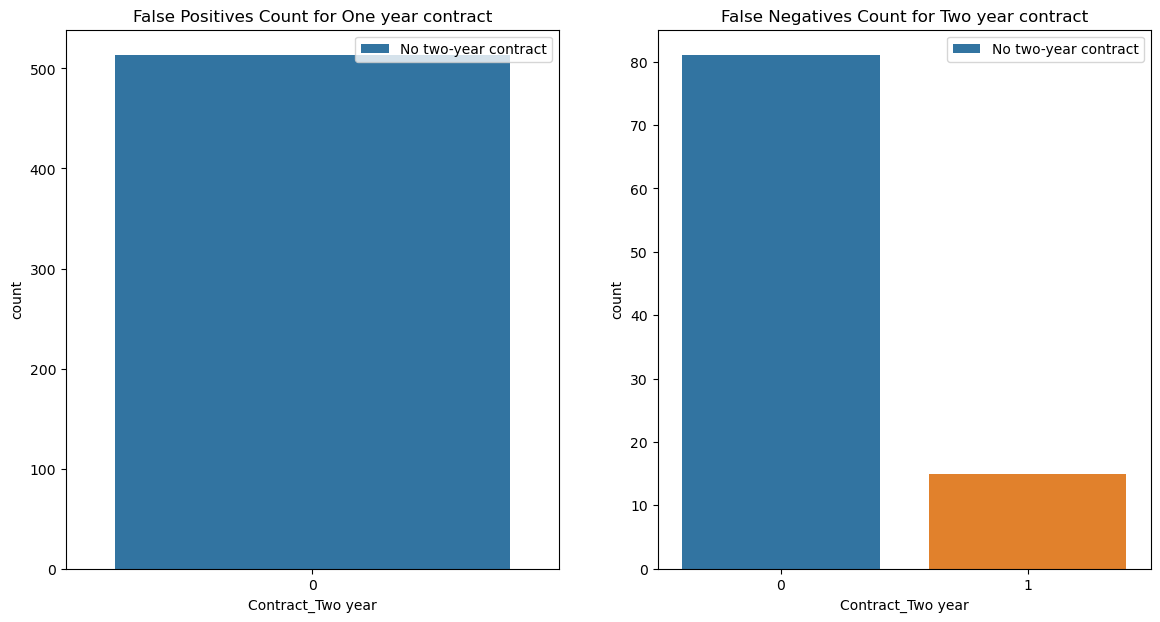

In [45]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x=false_positives['Contract_Two year'], label='No two-year contract')
plt.title('False Positives Count for One year contract')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=false_negatives['Contract_Two year'], label='No two-year contract')
plt.title('False Negatives Count for Two year contract')
plt.legend()

plt.show()

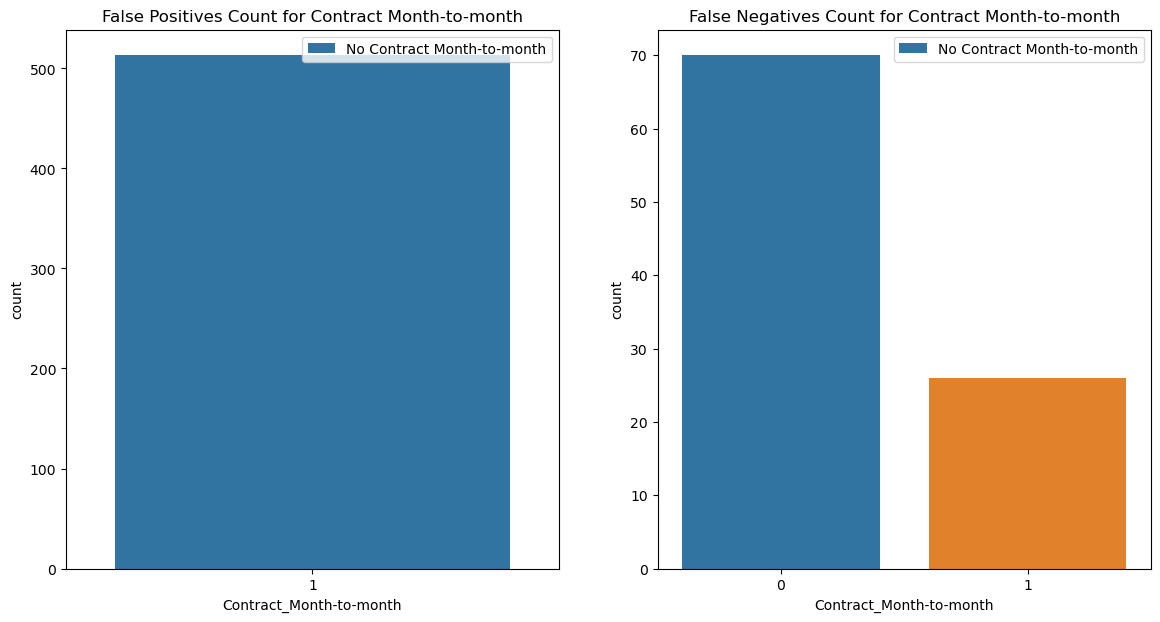

In [46]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.countplot(x=false_positives['Contract_Month-to-month'], label='No Contract Month-to-month')
plt.title('False Positives Count for Contract Month-to-month')
plt.legend()

plt.subplot(1, 2, 2)
sns.countplot(x=false_negatives['Contract_Month-to-month'], label='No Contract Month-to-month')
plt.title('False Negatives Count for Contract Month-to-month')
plt.legend()

plt.show()

Tenure: The false positives seem to be most frequent at lower tenure values, indicating that the model incorrectly predicts churn for customers with shorter tenures. On the other hand, false negatives are distributed more evenly across tenure but with a concentration at higher tenure values (50-70), suggesting that the model misses predicting churn for customers who have been with the company for longer.

Total Charges:  The majority of false positives occur in the lower range of total charges. This suggests that the model is more likely to incorrectly predict churn for customers who have lower total charges. It could mean that lower total charges are being interpreted by the model as a sign of potential churn. The distribution of false negatives is slightly more spread out across the range of total charges. However, there's a noticeable presence of false negatives throughout the range, indicating that the model misses predicting churn across various levels of total charges.

MonthlyCharges: There are more False Positives which occur in the middle range of monthly charges. The False negatives are distributed across the range of monthly charges, with some peaks.

One-year contract: All the False positives are of customers who do not have a one-year contract. For false negatives the model more often misses  predicting churn for customers who don't have a one-year contract compared to customers with a one-year contract.

Month-to-month contract: The model is incorrectly predicting churn only for customers who are on a month-to-month contract. This might indicate that the model overly associates month-to-month contracts with a higher likelihood of churn. For false negatives, the model is missing churn predictions more frequently for customers who are presumably on longer-term contracts. 

# Conclusion

##### Common Trends Across Models:

Tenure: All models seem to struggle with tenure, incorrectly predicting churn for newer customers (false positives) and missing churn predictions for long-standing customers (false negatives). This suggests a systemic issue across models, potentially due to overfitting to the majority class in the training data or inherent biases in the data collection process.

Total Charges: Lower total charges are consistently associated with false positives across models, indicating a possible perception that less invested customers are more likely to churn.

Contract Type: Month-to-month contracts are often associated with false positives, suggesting that models may overemphasize the volatility of such customers, while missing churn predictions for those on longer contracts.

##### Differences Across Models:

Monthly Charges: The Random Forest model shows some sensitivity to monthly charges with variable false positives in the higher range of monthly charges, while the SVM model's bias is showing for the middle range, suggesting it may treat this feature differently.

##### Implications for a Voting Classifier:

Given these observations, a voting classifier could potentially mitigate some of these biases by leveraging the diversity of predictions from each model. However, since some biases are common across all models (like the emphasis on tenure, total charges and month-to-month contracts), a voting classifier may not fully address these issues. It could, however, smooth out the variability seen in the interpretation of monthly charges.

Considering the common trends and differences across the Logistic Regression, Random Forest, and SVM models, it's apparent that creating a voting classifier might not be the most effective solution for improving churn prediction in this case. While a voting classifier can often capitalize on the diverse strengths of multiple models, the consistent biases related to tenure, total charges, and contract type suggest that these are systemic issues inherent to the data or the feature representation that wouldn't be resolved by simply combining model predictions.

In light of this, rather than combining models with shared biases, it would be more prudent to focus efforts on understanding the underlying reasons for these biases and to seek strategies that can directly mitigate them. This could involve acquiring more balanced datasets, employing different feature selection techniques, or exploring alternative modeling approaches that are less sensitive to the identified biases.